In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


from IPython import display
import seaborn as sn
import pandas as pd
import torch

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
#Read the dataset
normal = pd.read_csv('ptbdb_normal.csv',header = None)
abnormal = pd.read_csv('ptbdb_abnormal.csv', header = None)

In [14]:
print(normal.shape)
print(" ")
print(abnormal.shape)

(4046, 188)
 
(10506, 188)


In [15]:
normal[187].value_counts()

,count
187,
0.0,4046


In [16]:
abnormal[187].value_counts()

,count
187,
1.0,10506


In [17]:
#Concatenate them both
data = pd.concat([normal, abnormal])
data.shape

(14552, 188)

<Axes: >

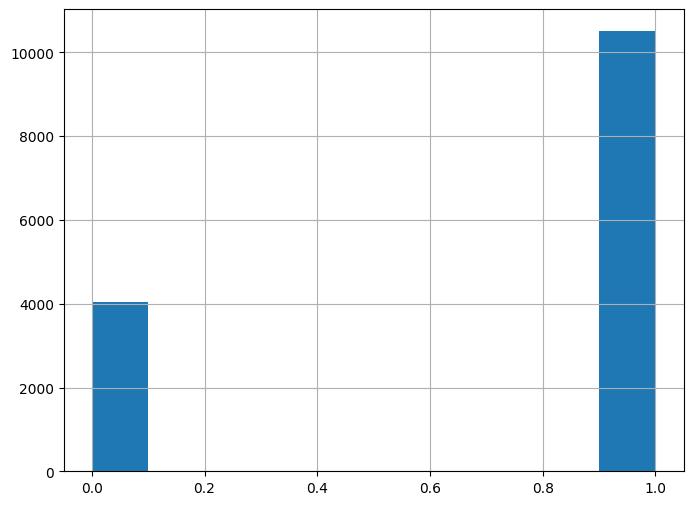

In [18]:
#Checking whether data is balanced
plt.figure(figsize = (8,6))
data[187].hist()

In [19]:
#Extract features and labels
X = data[data.columns[0:-1]].values
y = data[data.columns[-1]].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Transform to tensor and use dataloader

# Convert to tensor
train_data = torch.tensor(X_train)
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test)
test_labels = torch.tensor(y_test).long()

# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize, drop_last=True)

In [22]:
for X, y in train_loader:
    break
print(X.shape)

torch.Size([32, 187])


In [23]:
#Creating the transformer
model = nn.Sequential(
          nn.Linear(187,256),
          nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model = 256, nhead  = 8), num_layers = 6),
          nn.Linear(256,128),
          nn.Linear(128,64),
          nn.Linear(64,2),
          )

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [24]:
model

Sequential(
  (0): Linear(in_features=187, out_features=256, bias=True)
  (1): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [28]:
#Setting early stop
class EarlyStoppingCriterion():
    def __init__(self, patience = 7, delta = 0,  trace_func = print):

        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [29]:
#Training
numepochs = 100
n_classes = 2
model.to(device)
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# Instantiating the early stopping
earlystopping = EarlyStoppingCriterion()


 # initialize losses
losses    = torch.zeros(numepochs)
trainAcc  = []
testAcc   = []
test_loss = []

for epoch in range(numepochs):
    model.train()

    # loop over training batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      ypred = model(X.float())
      loss = lossfun(ypred,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      ypred = ypred.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(ypred,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )


    # Average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # Average losses across the batches
    losses[epoch] = np.mean(batchLoss)

    # test the model

    model.eval()

    with torch.no_grad(): # deactivates autograd
     batchAcc_test = []
     y_pred = np.zeros((X_test.shape[0] // batchsize , batchsize, n_classes))
     y_true = np.zeros((X_test.shape[0] // batchsize , batchsize))
     testbatch_losses = [] # This is new calculation

     for idx, (X,y) in enumerate(test_loader):

      X = X.to(device)
      y = y.to(device)
      ypred_t = model(X.float())
      ypred_t = ypred_t.cpu()
      y_pred[idx,:,:] = ypred_t
      y = y.cpu()
      y_true[idx,:] = y
      tloss = lossfun(ypred_t, y)
      # record test loss
      testbatch_losses.append(tloss.item())

      matches = torch.argmax(ypred_t,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc_test.append( accuracyPct )
    test_loss.append(np.mean(testbatch_losses) )
    testAcc.append( np.mean(batchAcc_test) )
    epoch_len = len(str(numepochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{numepochs:>{epoch_len}}] ' +

                     f'test_loss: {np.mean(testbatch_losses):.5f}')

    print(print_msg)

    earlystopping(np.mean(testbatch_losses), model)

    if earlystopping.early_stop:
        print("Early stopping")
        break

<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  0/100] test_loss: 0.45989


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  1/100] test_loss: 0.35289


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  2/100] test_loss: 0.31044


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accep

[  3/100] test_loss: 0.29259


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  4/100] test_loss: 0.26559


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  5/100] test_loss: 0.24625


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  6/100] test_loss: 0.22375


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  7/100] test_loss: 0.22898
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  8/100] test_loss: 0.22672
EarlyStopping counter: 2 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[  9/100] test_loss: 0.21769


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 10/100] test_loss: 0.19555


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 11/100] test_loss: 0.19470


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 12/100] test_loss: 0.17279


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 13/100] test_loss: 0.19035
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 14/100] test_loss: 0.16559


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 15/100] test_loss: 0.19656
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 16/100] test_loss: 0.16920
EarlyStopping counter: 2 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 17/100] test_loss: 0.16685
EarlyStopping counter: 3 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 18/100] test_loss: 0.14409


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 19/100] test_loss: 0.15786
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 20/100] test_loss: 0.15079
EarlyStopping counter: 2 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 21/100] test_loss: 0.12869


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 22/100] test_loss: 0.11254


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 23/100] test_loss: 0.13628
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 24/100] test_loss: 0.10593


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 25/100] test_loss: 0.11425
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 26/100] test_loss: 0.10501


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 27/100] test_loss: 0.09844


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 28/100] test_loss: 0.10391
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 29/100] test_loss: 0.11100
EarlyStopping counter: 2 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 30/100] test_loss: 0.09544


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 31/100] test_loss: 0.09979
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 32/100] test_loss: 0.08788


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 33/100] test_loss: 0.09629
EarlyStopping counter: 1 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 34/100] test_loss: 0.10429
EarlyStopping counter: 2 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 35/100] test_loss: 0.12345
EarlyStopping counter: 3 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 36/100] test_loss: 0.09005
EarlyStopping counter: 4 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 37/100] test_loss: 0.12283
EarlyStopping counter: 5 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t


[ 38/100] test_loss: 0.11176
EarlyStopping counter: 6 out of 7


<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y
<ipython-input-29-1370444237>:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred[idx,:,:] = ypred_t
<ipython-input-29-1370444237>:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_true[idx,:] = y


[ 39/100] test_loss: 0.09484
EarlyStopping counter: 7 out of 7
Early stopping


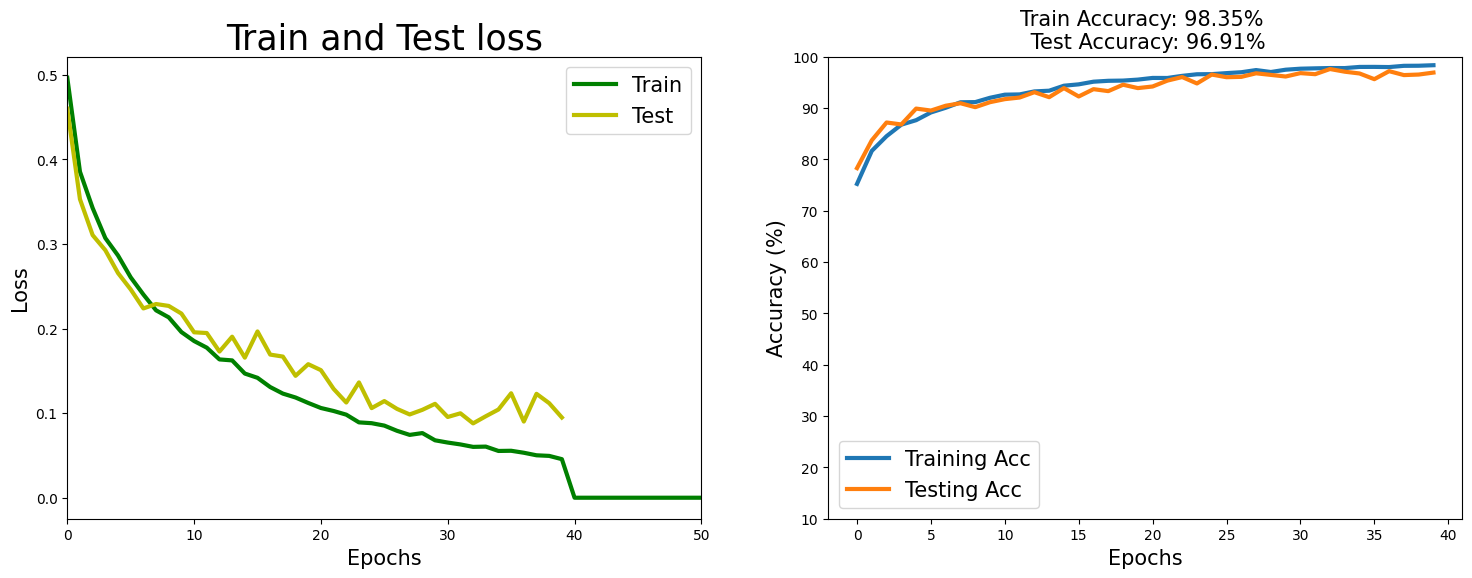

In [30]:
#Performance vis
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].plot(test_loss,'y', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].set_xlim([0,50])
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Train and Test loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()